In [ ]:
1. data
2. model training: embedding + logistic
3. emoji
4. test

In [1]:
import pandas as pd
import numpy as np
from gensim.models import FastText
import pickle
import re
import time
import nltk
from nltk.corpus import wordnet
from sklearn import model_selection
from sklearn import metrics,preprocessing
from sklearn.linear_model import LogisticRegression
import json
from uniseg.graphemecluster import grapheme_clusters
import regex


In [2]:
from random import seed
from random import sample

Project Summary

Introduction:
Public displaying the mandatory memos of the transactions, Venmo is a social digital wallet for sharing payments with friends. It serves as a portal into the offline spending behavior of users. Though not including all the consumption, it provides a great supplement to understanding spending in various categories, comparing to the data source of a specific company.

Methods:
Utilizing that data, I identified the use case for each transaction and investigated the spending behavior of users, defined as the proportions people spend on different categories. 
To achieve this goal, I built a multinomial logistic model to predict the probabilities of different categories with F1 score of 0.947, which was trained with features to be the vectorized text and true labels obtained through the dictionary-based approach. 

Challenge:
The challenge was to interpret emoji and abbreviations in informal English. With the linguistic descriptions of emoji obtained from EmojiNet, emojis are represented by the average word vector of their description. As for abbreviations, by vectorizing words based on n-grams, out-of-vocabulary words could be identified and the result proved to be reasonable.

original data, text manipulation, fasttext, emoji, logistic




<font color='purple'>

# 1. Original data

    including user ID, datetime, description and other irrelevant information.

    Data size: 3,599,970

    Percentage containing text: 37.6%

    Percentage containing emoji: 74.8%

In [2]:
orig_sample=pd.read_csv('/Users/yichuan/Desktop/Venmo project/data/venmoSample.csv')

In [3]:
orig_sample=orig_sample[1:3600000]  # this is half of the sample I acquired

In [4]:
orig_sample.isnull().sum()

user1                0
user2                0
transaction_type     0
datetime             0
description         29
is_business          0
story_id             0
dtype: int64

In [4]:
# filter out missing value
orig_sample=orig_sample.dropna()

In [6]:
orig_sample.shape

(3599970, 7)

In [7]:
orig_sample.head()

,user1,user2,transaction_type,datetime,description,is_business,story_id
1,5109483,4782303,payment,2015-06-17 04:37:04,Costco,False,5580f9702b64f70ab0114e94
2,4322148,3392963,payment,2015-06-19 00:05:31,Sweaty balls,False,55835ccb1a624b14ac62cef4
3,469894,1333620,charge,2016-06-03 16:34:13,🎥,False,5751b185cd03c9af224c0d17
4,2960727,3442373,payment,2016-05-29 16:23:42,⚡,False,574b178ecd03c9af22cf67f4
5,3977544,2709470,payment,2016-09-29 15:12:07,Chipotlaid,False,57ed2f4723e064eac0879304


<font color='purple'>

# 2. Identify use case through the dictionary-based approach. 

    The results of classification are true labels to feed into a logistic model.


<font color='purple'>

2.1 Import manually created dict 
    
    1. Manully created a dictionary that categorizes the 2000 most frequent words in memos into 9 groups, because of the lack of existing dictionary for categorizing words into money buckets.

    2. Leveraging the emoji dictionary from EmojiPedia, including 664 emojis. Emoji is hard to interpret. Luckily, the website EmojiPedia provides categorized emoji, including transportation, food...

    3. Divide use case into 9 categories: People*, Food, Event*, Activity, Travel, Transportation, Utility, Cash, Illegal/Sarcasm
    
        People: some nice sentiments 
        Event: special days 
    

In [4]:
word_dict=pd.read_csv('/Users/yichuan/Desktop/Venmo project/data/Venmo_Word_Classification_Dictionary.csv')

emoji_dict=pd.read_csv("/Users/yichuan/Desktop/Venmo project/data/Venmo_Emoji_Classification_Dictionary.csv")

In [5]:
word_dict.head()

,People,Food,Event,Activity,Travel,Transportation,Utility,Cash,Illegal/Sarcasm
0,friend,food,birthday,ball,beach,lyft,bill,atm,addiction
1,friendship,bbq,christmas,boat,place,uber,cable,bank,drug
2,baby,bean,happy,bar,la,cab,fee,cash,wangs
3,boy,latte,bday,book,world,bus,electric,money,weed
4,girl,breakfast,wedding,club,hotel,car,electricity,buck,anal


In [6]:
emoji_dict.head()

,Event,Travel,Food,Activity,Transportation,People,Utility
0,🇦🇺,🏔,🍇,👾,🚄,😀,⚡
1,🇫🇷,⛰,🍈,🕴,🚅,😃,💡
2,🎂,🌋,🍉,🎪,🚆,😄,🔌
3,🛍,🗻,🍊,🎭,🚇,😁,📺
4,🇨🇦,🏕,🍋,🎨,🚈,😆,🔌


In [133]:
# Reform dataframes into a dictionary and filter out nan
new_dict = word_dict.to_dict(orient='list')
filtered = {k: [x for x in v if str(x)!='nan'] for k, v in new_dict.items()}
new_dict.clear()
new_dict.update(filtered)

emoji_dict = emoji_dict.to_dict(orient='list')
filtered = {k: [x for x in v if str(x)!='nan'] for k, v in emoji_dict.items()}
emoji_dict.clear()
emoji_dict.update(filtered)

for col in emoji_dict.keys():
    new_dict[col]=new_dict[col]+ emoji_dict[col]

In [134]:
sum([len(emoji_dict[x]) for x in emoji_dict.keys()])

664

In [11]:
new_dict.keys()

dict_keys(['People', 'Food', 'Event', 'Activity', 'Travel', 'Transportation', 'Utility', 'Cash', 'Illegal/Sarcasm'])

In [135]:
new_dict_list=[new_dict[x] for x in new_dict.keys()]

<font color='purple'>

2.2 Emoji/ text preprocessing

In [121]:
# 1. Remove punctuations
# or the puctuations would be treated as emoji
punctuations = '~|`|\!|@|#|$|%|^|&|\*|\(|\)|-|\+|=|_|\{|\}|\[|\]|;|:|\?|\.|,|<|>|/|\'|\"'
orig_sample['desc_punc_remove'] = [re.sub(punctuations,'',x) for x in orig_sample['description']]

In [122]:
# 2. Preprocess emoji
# create new column 'emoji': keep only emojis from memos
orig_sample['emoji'] = [re.sub('[\w\s]','',x) for x in orig_sample['desc_punc_remove']]

<font color='red'>

# Attention

In [125]:
# Find a proper way to tokenize emojis as users perceived
# Some composed emojis are represented by several code points. Though they displayed as a single emoji, the result of the code 'len()' would be more than one.
# we don't want those things happen, for 
#   a) users put same effort to type them as type other emoji 
#   b) their meaning might not be the simple combination of the composed emoji

def token_emoji(emoji):
    '''
    return emoji tokens
    Input: string
    Output: list
    '''
    return regex.findall(r'\X',emoji)

In [20]:
[x for x in '🇫🇷🇫🇷🇫🇷🙅🏽']

['🇫', '🇷', '🇫', '🇷', '🇫', '🇷', '🙅', '🏽']

In [21]:
regex.findall(r'\X','🇫🇷🇫🇷🇫🇷🙅🏽')

['🇫🇷', '🇫🇷', '🇫🇷', '🙅🏽']

In [127]:
# Tokenize emoji
orig_sample['emoji_token'] = [token_emoji(x) for x in orig_sample['emoji']]  # quick

In [128]:
# 3. Preprocess text

orig_sample['text']=[re.sub('[^\w\s]','',x) for x in orig_sample['desc_punc_remove']]

In [28]:


# Functions for cleaning data

def wordnet_pos(tag):
    """
    Map a Brown POS tag to a WordNet POS tag.
    Input: list
    Output: list
    """
    
    table = {"N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV, "J": wordnet.ADJ}
    
    # Default to a noun.
    return table.get(tag[0], wordnet.NOUN)

lemmatizer = nltk.WordNetLemmatizer()

def clean_data(data):
    '''
    Text Preprocessing, including tokenization, lemmatization and stop words removing
    Input: string
    Output: list
    '''
    if data=='':
        return []
    else:
        words = nltk.word_tokenize(data)
        words = [w.lower() for w in words]

        word_tags = nltk.pos_tag(words)
        words=[lemmatizer.lemmatize(w, wordnet_pos(t)) for (w, t) in word_tags]

        stopwords = nltk.corpus.stopwords.words("english") + ["say","get","make","also","would","could","take","go"]

        #isalnum()True if all characters in the string are alphanumeric (either alphabets or numbers)
        words=[w for w in words if w not in stopwords]

        return words


In [17]:
orig_sample['clean_text']=[clean_data(x) for x in orig_sample['text']]

<font color='purple'>

2.3 Classification based on maually created dictionary

In [136]:
# function for classification

def classify_all(a):
    '''
    return observation scores, which is defined as the number of tokens found in each category
    input: list
    output: list
    '''
    s=[0]*9
    for j in range(9):
        for i in a:
            if (i in new_dict_list[j]):
                s[j]=s[j]+1
    return [x if x<=1 else 1 for x in s]

In [131]:
# Create column: new_list-- list of emoji token and word token
# keep unique elements only: to simplify classification, as we are having binary classification problem    
orig_sample['new_list']=orig_sample['emoji_token']+orig_sample['clean_text']
orig_sample['new_list']=[list(set(x)) for x in orig_sample['new_list']]  


In [137]:
# Apply classification function
result_df=pd.DataFrame([classify_all(x) for x in orig_sample['new_list']])

In [138]:
c=['People', 'Food', 'Event', 'Activity', 'Travel', 'Transportation', 'Utility', 'Cash', 'Illegal/Sarcasm']

result_df.columns=c

In [140]:
# Create column: total number of categories that occur 
result_df['number of classified']=result_df.sum(axis=1)

In [ ]:
#Snapshot of 'result_df':

# Column 'People' to column 'Illegal/Sarcasm' are the results of classification
# Column 'number of classified' is the sum of scores, idicating the number of categories found in certain sample

# further used for training logistic model

In [141]:
result_df.head()

,People,Food,Event,Activity,Travel,Transportation,Utility,Cash,Illegal/Sarcasm,number of classified
0,0,1,0,0,0,0,0,0,0,1
1,0,0,0,1,0,0,0,0,0,1
2,0,0,1,0,0,0,0,0,0,1
3,0,0,0,0,0,0,1,0,0,1
4,0,0,0,0,0,0,0,0,0,0


In [144]:
# Add on emoji and text column to 'result_df'
result_df['description']=orig_sample['description']
result_df['emoji_token']=orig_sample['emoji_token']
result_df['clean_text']=orig_sample['clean_text']


<font color='purple'>

2.4 Distribution

<font color='purple'>

2.4.1 Emoji/ text percentage 

In [50]:
# number of samples that contain emoji
sum([x!='' for x in orig_sample['emoji']])

1338217

In [8]:
1338217/3555570

0.3763720022387409

In [51]:
# number of samples that contain text
sum([x!='' for x in orig_sample['text']])

2658708

In [9]:
2658708/3555570

0.7477585872307394

<font color='purple'>

2.4.2 Distributions of number of characters and emojis
    
    Here I look at 'number of character' instead of 'number of words' because the number of character is a better measure of the effort people put into typing. 

In [71]:
# distribution of number of characters

countText=[len(x) for x in orig_sample['text']]

pd.Series(countText).value_counts()

0        941262
4        230125
5        208348
6        164039
7        162917
          ...  
647           1
646           1
43245         1
645           1
1978          1
Length: 785, dtype: int64

In [147]:
# distribution of number of emojis

countEmoji=[len(x) for x in orig_sample['emoji_token']]

pd.Series(countEmoji).value_counts()

0      2261753
1       777539
2       242791
3       162702
4        69401
        ...   
261          1
260          1
258          1
252          1
149          1
Length: 282, dtype: int64

<font color='purple'>

2.4.3 Distribution of number of classified observations

    Defining 'classified observations' as those contain in-dictionary words or emojis

In [148]:
result_df['number of classified'].value_counts()

1    1877856
0    1349712
2     318524
3      46075
4       6571
5        980
6        188
7         39
8         15
9         10
Name: number of classified, dtype: int64

In [89]:
(3555570-1877856-1349712)/3555570

0.09225018773361233

In [151]:
1-1349712/3555570

0.6203950421451413

<font color='purple'>

# 3. Build FastText model

In [9]:
# fasttext training: clean text


In [3]:

result=pd.read_csv('/Users/yichuan/Desktop/Venmo project/word classifier/output data/RESULT_DF.csv')


In [3]:
result.head()

,Unnamed: 0,index,People,Food,Event,Activity,Travel,Transportation,Utility,Cash,Illegal/Sarcasm,number of classified,description,emoji_token,clean_text
0,0,0,0,1,0,0,0,0,0,0,0,1,Costco,[],['costco']
1,1,1,0,0,0,1,0,0,0,0,0,1,Sweaty balls,[],"['sweaty', 'ball']"
2,2,2,0,0,1,0,0,0,0,0,0,1,🎥,['🎥'],['']
3,3,3,0,0,0,0,0,0,1,0,0,1,⚡,['⚡'],['']
4,4,4,0,0,0,0,0,0,0,0,0,0,Chipotlaid,[],['chipotlaid']


In [4]:
result['clean_text']=[re.sub(r'[\'\[\] ]','',x).split(',') for x in result['clean_text']]


In [5]:
text_list=list(result['clean_text'])

In [68]:
# Model training

### Parameters:
# size: Dimensionality of the word vectors.
# window: The maximum distance between the current and predicted word within a sentence.
# min_count: The model ignores all words with total frequency lower than this.
# workers: Use these many worker threads to train the model (=faster training with multicore machines).
# min_n: Minimum length of char n-grams to be used for training word representations.
# max_n: Max length of char ngrams to be used for training word representations.

ft_clean = FastText(text_list, size=200, window=5, min_count=150, workers=4, min_n=3, max_n=10)

In [101]:
ft_clean.wv.most_similar('pge') 

# almost all of them are energe companies(bge, sdge, xfinity, pgw, pepco, utils, peco, entergy)
# only two excepts but highly related:
# sewage(wastewater)
# verizon(wireless product)

[('bge', 0.9215357303619385),
 ('sdge', 0.8941078186035156),
 ('xfinity', 0.8506375551223755),
 ('pgw', 0.8435612916946411),
 ('pepco', 0.8222055435180664),
 ('sewage', 0.8149155378341675),
 ('utils', 0.8075290322303772),
 ('peco', 0.804094135761261),
 ('entergy', 0.8040465116500854),
 ('verizon', 0.7912341952323914)]

In [6]:
ft_clean = FastText(text_list, size=50, window=5, min_count=150, workers=4, min_n=3, max_n=10)

In [11]:
ft_clean.wv.most_similar('pge') 


[('bge', 0.9528211355209351),
 ('sdge', 0.9260073304176331),
 ('xfinity', 0.874472975730896),
 ('peco', 0.8674561977386475),
 ('utility', 0.8651200532913208),
 ('util', 0.8600059747695923),
 ('pepco', 0.8576865196228027),
 ('utils', 0.8558487892150879),
 ('cableinternet', 0.8535972833633423),
 ('pgw', 0.846127986907959)]

In [7]:
ft_clean.save('v_cleaned_fast_model_50d')

<font color='green'>
    
    
### IMPORT pretrained fasttext model

In [28]:
ft_clean = FastText.load('v_cleaned_fast_model_50d')

In [8]:
def avg_vec(x):
    '''
    Return the average vector of a list of tokens
    Input: list
    Output: list
    '''
    return sum([ft_clean.wv[word] for word in x])/len(x)

<font color='purple'>

# 4. Representing emojis as their linguistic description from EmojiNet

In [16]:
# emojinet
with open('/Users/yichuan/Desktop/Venmo project/data/emojiNet/emojis.json') as json_file:
    emojiNet = json.load(json_file)

In [17]:
emojiNet_df=pd.DataFrame(emojiNet)

In [18]:
emojiNet_df.head()

,category,keywords,definition,unicode,name,shortcode,senses
0,Miscellaneous Symbols And Pictographs -> Emoji...,"[dark skin tone, hand, forbidden, gesture, wom...","The Woman Gesturing Not OK, Type-6 emoji is a ...",U+1F645 U+1F3FF U+200D U+2640 U+FE0F,woman gesturing NO: dark skin tone,None,{'adjectives': [{'bn:00104562a': ['Contrary to...
1,Miscellaneous Symbols And Pictographs -> Emoji...,"[dark skin tone, woman, guard]","The Female Guard, Type-6 emoji is a sequence o...",U+1F482 U+1F3FF U+200D U+2640 U+FE0F,woman guard: dark skin tone,None,"{'adjectives': [], 'verbs': [{'bn:00090041v': ..."
2,None,"[racing, running, woman, marathon]",The female version of the ?? Runner emoji. The...,U+1F3C3 U+200D U+2640 U+FE0F,woman running,None,{'adjectives': [{'bn:00109994a': ['Of advancin...
3,Miscellaneous Symbols And Pictographs -> Emoji...,"[gymnastics, medium-light skin tone, woman, ca...","The Woman Doing Cartwheel, Type-3 emoji is a s...",U+1F938 U+1F3FC U+200D U+2640 U+FE0F,woman cartwheeling: medium-light skin tone,None,"{'adjectives': [], 'verbs': [{'bn:00084605v': ..."
4,None,"[woman, golf]",The female version of the ?? Golfer emoji. The...,U+1F3CC U+FE0F U+200D U+2640 U+FE0F,woman golfing,None,"{'adjectives': [], 'verbs': [{'bn:00088979v': ..."


In [29]:
keywords_vector=pd.DataFrame([avg_vec(x) for x in emojiNet_df['keywords']])  # average vector of keywords

In [30]:
keywords_vector['unicode']=emojiNet_df['unicode']

In [32]:
keywords_vector.to_csv('output data/EMOJI_vector.csv')

In [ ]:
keywords_vector=...

In [31]:
keyword_dict=keywords_vector.set_index('unicode').T.to_dict('list')


In [19]:
# recompute for 50-d vector
keywords_vector=pd.DataFrame([avg_vec(x) for x in emojiNet_df['keywords']])  # average vector of keywords
keywords_vector['unicode']=emojiNet_df['unicode']
keywords_vector.to_csv('output data/EMOJI_vector_50d.csv')
keyword_dict=keywords_vector.set_index('unicode').T.to_dict('list')


<font color='green'>
    
    
### IMPORT emoji vector

In [9]:
keywords_vector = pd.read_csv('output data/EMOJI_vector_50d.csv')

In [28]:
keywords_vector = keywords_vector.drop('Unnamed: 0',axis=1)

In [29]:
keyword_dict=keywords_vector.set_index('unicode').T.to_dict('list')


<font color='purple'>

# 5. Build logistic model

In [ ]:
# trained on clean text

<font color='purple'>

5.1 Data preprocessing

<font color='purple'>
    
5.1.1 Sebset uni-label data for training
    
    Some samples contain multiple keywords in different categories. That will make logistic model training much harder. So only keep those uni-label samples for training purpose.

In [313]:
# Create column: new_lst_of_lst
# for vector computation

orig_sample['new_lst_of_lst']=[[x,y] for x, y in zip(orig_sample['emoji_token'],orig_sample['clean_text'])]

result_df['new_lst_of_lst']=orig_sample['new_lst_of_lst']

In [315]:
## Dataset for logistic: all models (training and evaluation) is based on unilabel cases

result_uni_label=result_df[(result_df['number of classified']==1)]

In [323]:
result_uni_label.shape

(1877856, 15)

In [27]:
# The sample size is too large. Randomly choose 900,000 samples
seed(1)

sequence = [i for i in range(1877856)]

subset = sample(sequence, 900000)

In [331]:
result_uni_label_=result_uni_label.iloc[subset,:]

In [332]:
result_uni_label_.head()

,index,People,Food,Event,Activity,Travel,Transportation,Utility,Cash,Illegal/Sarcasm,number of classified,description,emoji_token,clean_text,new_lst_of_lst
538968,538968,0,0,0,1,0,0,0,0,0,1,Sox,[],[sox],"[[], [sox]]"
2287078,2287078,0,1,0,0,0,0,0,0,0,1,🍔🍟,"[🍔, 🍟]",[],"[[🍔, 🍟], []]"
3406446,3406446,0,0,0,1,0,0,0,0,0,1,Ticket,[],[ticket],"[[], [ticket]]"
3225192,3225192,0,0,0,0,0,0,0,0,1,1,Blood transfusion,[],"[blood, transfusion]","[[], [blood, transfusion]]"
3070350,3070350,0,1,0,0,0,0,0,0,0,1,🍗🍗🍗🍗🍗,"[🍗, 🍗, 🍗, 🍗, 🍗]",[],"[[🍗, 🍗, 🍗, 🍗, 🍗], []]"


------

2/24

In [10]:
### 50-d
result['emoji_token']=[re.sub(r'[\'\[\] ]','',x).split(',') for x in result['emoji_token']]


In [11]:
result['new_lst_of_lst']=[[x,y] for x, y in zip(result['emoji_token'],result['clean_text'])]


In [12]:
nuilabel=result[result['number of classified']==1]

In [13]:
nuilabel.shape

(1877856, 16)

In [14]:
# The sample size is too large. Randomly choose 900,000 samples
seed(1)

sequence = [i for i in range(1877856)]

subset = sample(sequence, 90000)

In [15]:
uni_label=nuilabel.iloc[subset,:]

In [16]:
training,testing=model_selection.train_test_split(uni_label,test_size = .2,random_state=1)

In [17]:
training.shape

(72000, 16)

In [30]:
x_train=pd.DataFrame([convert_to_vector(x) for x in list(training['new_lst_of_lst'])])

In [31]:
x_test=pd.DataFrame([convert_to_vector(x) for x in list(testing['new_lst_of_lst'])])

In [32]:
# Create label vector: y

c=['People', 'Food', 'Event', 'Activity', 'Travel', 'Transportation',
       'Utility', 'Cash', 'Illegal/Sarcasm']
y_train=training[c]

y_train['label']=y_train.idxmax(axis=1)
y_train["label"] = y_train["label"].astype('category')
y_train["label_code"] = y_train["label"].cat.codes

dict(enumerate(y_train["label"].cat.categories))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas

{0: 'Activity',
 1: 'Cash',
 2: 'Event',
 3: 'Food',
 4: 'Illegal/Sarcasm',
 5: 'People',
 6: 'Transportation',
 7: 'Travel',
 8: 'Utility'}

In [33]:
y_train=y_train.loc[:,'label_code']

In [34]:
# Create label vector: y

c=['People', 'Food', 'Event', 'Activity', 'Travel', 'Transportation',
       'Utility', 'Cash', 'Illegal/Sarcasm']
y_test=testing[c]

y_test['label']=y_test.idxmax(axis=1)
y_test["label"] = y_test["label"].astype('category')
y_test["label_code"] = y_test["label"].cat.codes

dict(enumerate(y_test["label"].cat.categories))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas

{0: 'Activity',
 1: 'Cash',
 2: 'Event',
 3: 'Food',
 4: 'Illegal/Sarcasm',
 5: 'People',
 6: 'Transportation',
 7: 'Travel',
 8: 'Utility'}

In [35]:
y_test=y_test.loc[:,'label_code']

2/24

jump to log reg model training

-------

<font color='purple'>

5.1.2 True label

In [333]:
# Create label vector: y
c=['People', 'Food', 'Event', 'Activity', 'Travel', 'Transportation',
       'Utility', 'Cash', 'Illegal/Sarcasm']
y_dataset=result_uni_label_[c]

In [334]:

# Reform y
# convert one-hot to categorical variable
y_dataset['label']=y_dataset.idxmax(axis=1)
y_dataset["label"] = y_dataset["label"].astype('category')
y_dataset["label_code"] = y_dataset["label"].cat.codes

dict(enumerate(y_dataset["label"].cat.categories))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

{0: 'Activity',
 1: 'Cash',
 2: 'Event',
 3: 'Food',
 4: 'Illegal/Sarcasm',
 5: 'People',
 6: 'Transportation',
 7: 'Travel',
 8: 'Utility'}

In [335]:
y_data=y_dataset.loc[:,'label_code']

In [336]:
# Split training and testing sets
    
training, testing, y_train, y_test = model_selection.train_test_split(result_uni_label_,y_data,test_size = .2,random_state=1)


In [337]:
training.shape, testing.shape

((720000, 15), (180000, 15))

<font color='purple'>

5.1.3 Feature extraction
    
    Features for the logistic model are the word embedding. So need to convert emojis and text to word vectors.

In [19]:
# Functions to convert emojis and text to vector, and return the average vector

def decode_emoji(x):
    '''
    Return unicode of emoji
    Input: string
    Output: string
    '''
    d=[]
    for i in x:
        d.append('U+{:X}'.format(ord(i)))
    return ' '.join(d)



In [ ]:
# try except (for conver_to_vector func)

In [22]:
'U+1F645 U+1F3FF U+200D U+2640 U+FE0F' in keyword_dict.keys()

True

In [ ]:
def emoji_vec_try(x):
    try:
        emoji_unicode=[decode_emoji(x) for x in emoji_list]
        emoji_vector=sum([np.asarray(keyword_dict[x]) for x in emoji_unicode])
    except KeyError:
        emoji_list=[x for x in emoji_list if decode_emoji(x) in keyword_dict.keys()]
        if emoji_l>0:
            emoji_unicode=[decode_emoji(x) for x in emoji_list]
            emoji_vector=sum([np.asarray(keyword_dict[x]) for x in emoji_unicode])
        else:
            emoji_vector=np.asarray([0]*200)

In [20]:
def convert_to_vector(x):
    '''
    Convert emojis and text to vector and return the average vector
    input: emoji token (list of two)(depends on 'new_lst_of_lst')
    output: average vector of keywords
    '''
    emoji_list=x[0]
    text_list=x[1]
    emoji_l=len(emoji_list)
    text_l=len(text_list)
    
    if text_l>0:
        text_vector=sum([ft_clean.wv[word] for word in text_list])
    else:
        text_vector=np.asarray([0]*200)
        
    if emoji_l>0:
        emoji_unicode=[decode_emoji(x) for x in emoji_list]
        try:
            emoji_vector=sum([np.asarray(keyword_dict[x]) for x in emoji_unicode])
        except KeyError:
            emoji_unicode=[x for x in emoji_unicode if x in keyword_dict.keys()]
            if emoji_l>0:
                emoji_vector=sum([np.asarray(keyword_dict[x]) for x in emoji_unicode])
            else:
                emoji_vector=np.asarray([0]*200)
    else:
        emoji_vector=np.asarray([0]*200)
        
    if (text_l>0) | (emoji_l>0): 
        
        vector=(text_vector + emoji_vector)/(emoji_l+text_l)
    else:
        vector=np.asarray([0]*200)
        
    return vector

In [339]:
x_clean_train=pd.DataFrame([convert_to_vector(x) for x in list(training['new_lst_of_lst'])])

In [340]:
x_clean_test=pd.DataFrame([convert_to_vector(x) for x in list(testing['new_lst_of_lst'])]) # done!

In [341]:
x_clean_train.shape, x_clean_test.shape

((720000, 200), (180000, 200))

<font color='purple'>
    
5.2 Model training

In [347]:
# Create one-vs-rest logistic regression object
lreg_1 = LogisticRegression(random_state=0, multi_class='multinomial', solver='newton-cg')

# Train model # feature_train, y_train
model_1 = lreg_1.fit(x_clean_train, y_train)

------

2/24

In [36]:
# 50-d

# Create one-vs-rest logistic regression object
lreg_1 = LogisticRegression(random_state=0, multi_class='multinomial', solver='newton-cg')

# Train model # feature_train, y_train
model_1 = lreg_1.fit(x_train, y_train)

In [37]:
filename = 'logistic_model_c_50.sav'
pickle.dump(model_1, open(filename, 'wb'))

<font color='green'>
    
    
### IMPORT pretrained log reg model

In [ ]:
# load
filename = 'Embed_Logistic_comb/logistic_model_c_50.sav'
model_1 = pickle.load(open(filename, 'rb'))

2/24

------

<font color='purple'>

5.3 Model evaluating

<font color='purple'>
    
5.3.1 Evaluating on uni-label samples

In [348]:
y_pred=model_1.predict(x_clean_test)

In [349]:
# accuracy

score = model_1.score(x_clean_test, y_test)
score

0.9322833333333334

In [350]:
# f1 score
metrics.f1_score(y_test, y_pred,average='weighted')

0.9319349521687875

In [351]:
# confusion matrix
metrics.confusion_matrix(y_test, y_pred)


array([[23220,     5,   184,   519,   266,   765,   146,   133,   251],
       [   12,  1043,     2,    29,    15,    16,     1,    20,     5],
       [  320,     1,  3619,   219,    57,   349,    62,    36,    56],
       [  423,    22,    84, 64694,   337,   701,    43,    45,   287],
       [  384,     9,    70,   634,  8621,   505,    79,    37,   123],
       [  652,     9,   172,   604,   296, 23276,    26,    82,   208],
       [  264,     3,    20,   110,    46,    78, 13383,    86,   119],
       [  218,    12,    24,   107,    33,   255,   118,  4363,   169],
       [  307,    11,    60,   304,   171,   231,    51,    91, 25592]])

In [ ]:
# auc score

In [352]:
y_pred_prob=model_1.predict_proba(x_clean_test)

In [353]:
metrics.roc_auc_score(y_test,y_pred_prob,average='macro',multi_class='ovr')

0.9938928917424595

In [354]:
metrics.roc_auc_score(y_test,y_pred_prob,average='weighted',multi_class='ovr')

0.9947828738814659

In [355]:
metrics.roc_auc_score(y_test,y_pred_prob,average='macro',multi_class='ovo')

0.9923139076499073

In [356]:
metrics.roc_auc_score(y_test,y_pred_prob,average='weighted',multi_class='ovo')

0.9935639555325035

------

2/24

In [54]:
# 50-d

y_pred = model_1.predict(x_test)
score = model_1.score(x_test, y_test)
f1 = metrics.f1_score(y_test, y_pred,average='weighted')
score,f1

(0.8602777777777778, 0.8588270461186941)

In [55]:
# 50-d

y_pred_prob=model_1.predict_proba(x_test)
metrics.roc_auc_score(y_test,y_pred_prob,average='macro',multi_class='ovr')

0.9722245242828106

In [56]:
multi_label=result[(result['number of classified']>1)]

In [57]:
multi_label=multi_label.reset_index()
multi_label=multi_label.drop(['level_0'],axis=1)
# Randomly select 200,000 samples
sequence = [i for i in range(372402)]

subset = sample(sequence, 20000)

multi_label=multi_label.iloc[subset,:]

In [59]:
c=['Activity', 'Cash', 'Event','Food','Illegal/Sarcasm', 'People', 'Transportation','Travel', 'Utility']
y_multi_test=multi_label[c]

y_multi_test=np.asarray(y_multi_test)

In [60]:
x_multi_test=pd.DataFrame([convert_to_vector(x) for x in multi_label['new_lst_of_lst']])

In [61]:
y_multi_pred=model_1.predict(x_multi_test)
y_multi_pred_prob=model_1.predict_proba(x_multi_test)

In [62]:
metrics.roc_auc_score(y_multi_test, y_multi_pred_prob, average='macro', multi_class='ovr')

0.8606582710967167

2/24

------

In [357]:
# ruc curve

In [362]:
y = preprocessing.label_binarize(y_test, classes=[0, 1, 2,3,4,5,6,7,8])

y_score = model_1.decision_function(x_clean_test)

In [364]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(9):
    fpr[i], tpr[i], _ = metrics.roc_curve(y[:, i], y_score[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])

In [365]:
## from the official document
fpr["micro"], tpr["micro"], _ = metrics.roc_curve(y.ravel(), y_score.ravel())
roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])

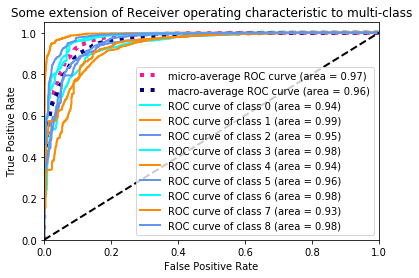

In [369]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(9)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(9):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= 9

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = metrics.auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
lw=2
for i, color in zip(range(9), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

<font color='purple'>

5.3.2 Evaluating on multi-lable samples

<font color='purple'>

5.3.2.1 Subset samples with multi-label

In [370]:
# 
result_multi_label=result_df[(result_df['number of classified']>1)]

In [371]:
result_multi_label.shape

(372402, 15)

In [373]:
result_multi_label=result_multi_label.reset_index()

In [375]:
result_multi_label=result_multi_label.drop(['level_0'],axis=1)

In [378]:

# Randomly select 200,000 samples
sequence = [i for i in range(372402)]

subset = sample(sequence, 200000)

result_multi_label_test=result_multi_label.iloc[subset,:]

<font color='purple'>

5.3.2.2 Data preprocessing

In [379]:
# dataset for training
# 
c=['Activity', 'Cash', 'Event','Food','Illegal/Sarcasm', 'People', 'Transportation','Travel', 'Utility']
y_dataset=result_multi_label_test[c]

y=np.asarray(y_dataset)

In [384]:
x_multi_test=pd.DataFrame([convert_to_vector(x) for x in result_multi_label_test['new_lst_of_lst']])

In [385]:
y_multi_pred=model_1.predict(x_multi_test)
y_multi_pred_prob=model_1.predict_proba(x_multi_test)

<font color='purple'>
    
5.3.2.3 Evaluation

In [386]:
# auc score
metrics.roc_auc_score(y, y_multi_pred_prob, average='macro', multi_class='ovr')

0.8662228175564667

In [387]:
metrics.roc_auc_score(y, y_multi_pred_prob, average='weighted', multi_class='ovr')

0.8683244251228978

In [388]:
metrics.roc_auc_score(y, y_multi_pred_prob, average='weighted', multi_class='ovo')

0.8683244251228978

In [389]:
metrics.roc_auc_score(y, y_multi_pred_prob, average='macro', multi_class='ovo')

0.8662228175564667

In [390]:
# ruc curve
y_score_m = model_1.decision_function(x_multi_test)

In [391]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(9):
    fpr[i], tpr[i], _ = metrics.roc_curve(y[:, i], y_score_m[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])

In [392]:
fpr["micro"], tpr["micro"], _ = metrics.roc_curve(y.ravel(), y_score_m.ravel())
roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])

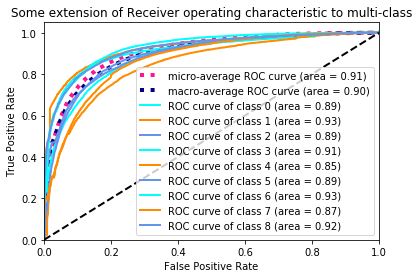

In [393]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(9)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(9):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= 9

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = metrics.auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(9), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# before evaluate on clean text

In [ ]:
# now evaluate on simple cleaned text

In [4]:
result=pd.read_csv('/Users/yichuan/Desktop/Venmo project/word classifier/output data/RESULT_DF.csv')

In [10]:
result.head()

,Unnamed: 0,index,People,Food,Event,Activity,Travel,Transportation,Utility,Cash,Illegal/Sarcasm,number of classified,description,emoji_token,clean_text
0,0,0,0,1,0,0,0,0,0,0,0,1,Costco,[],['costco']
1,1,1,0,0,0,1,0,0,0,0,0,1,Sweaty balls,[],"['sweaty', 'ball']"
2,2,2,0,0,1,0,0,0,0,0,0,1,🎥,['🎥'],['']
3,3,3,0,0,0,0,0,0,1,0,0,1,⚡,['⚡'],['']
4,4,4,0,0,0,0,0,0,0,0,0,0,Chipotlaid,[],['chipotlaid']


In [11]:
result.shape

(3599970, 15)

In [5]:
# 1. Remove punctuations
# or the puctuations would be treated as emoji
punctuations = '~|`|\!|@|#|$|%|^|&|\*|\(|\)|-|\+|=|_|\{|\}|\[|\]|;|:|\?|\.|,|<|>|/|\'|\"'
result['desc_punc_remove'] = [re.sub(punctuations,'',x) for x in result['description']]

In [6]:
result['text']=[re.sub('[^\w\s]','',x) for x in result['desc_punc_remove']]

In [13]:
unilabel_set=result[(result['number of classified']==1)]

In [14]:
unilabel_set.shape

(1877856, 17)

In [16]:
unilabel_set.head()

,Unnamed: 0,index,People,Food,Event,Activity,Travel,Transportation,Utility,Cash,Illegal/Sarcasm,number of classified,description,emoji_token,clean_text,desc_punc_remove,text
0,0,0,0,1,0,0,0,0,0,0,0,1,Costco,[],['costco'],Costco,Costco
1,1,1,0,0,0,1,0,0,0,0,0,1,Sweaty balls,[],"['sweaty', 'ball']",Sweaty balls,Sweaty balls
2,2,2,0,0,1,0,0,0,0,0,0,1,🎥,['🎥'],[''],🎥,
3,3,3,0,0,0,0,0,0,1,0,0,1,⚡,['⚡'],[''],⚡,
6,6,6,0,1,0,0,0,0,0,0,0,1,Food,[],['food'],Food,Food


In [15]:
unilabel_set_test=unilabel_set.iloc[0:1500,:]

In [16]:
# Functions for simple clean text
def clean_data(data):
    '''
    Text Preprocessing, including tokenization, lemmatization and stop words removing
    Input: string
    Output: list
    '''
    if data=='':
        return []
    else:
        words = nltk.word_tokenize(data)
        words = [w.lower() for w in words]

        stopwords = nltk.corpus.stopwords.words("english") + ["say","get","make","also","would","could","take","go"]

        #isalnum()True if all characters in the string are alphanumeric (either alphabets or numbers)
        words=[w for w in words if w not in stopwords]

        return words


In [19]:
clean_data('Costcoss')

['costcoss']

In [17]:
unilabel_set_test['simple_clean_text']=[clean_data(x) for x in unilabel_set_test['text']]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [18]:
unilabel_set_test.head()

,Unnamed: 0,index,People,Food,Event,Activity,Travel,Transportation,Utility,Cash,Illegal/Sarcasm,number of classified,description,emoji_token,clean_text,desc_punc_remove,text,simple_clean_text
0,0,0,0,1,0,0,0,0,0,0,0,1,Costco,[],['costco'],Costco,Costco,[costco]
1,1,1,0,0,0,1,0,0,0,0,0,1,Sweaty balls,[],"['sweaty', 'ball']",Sweaty balls,Sweaty balls,"[sweaty, balls]"
2,2,2,0,0,1,0,0,0,0,0,0,1,🎥,['🎥'],[''],🎥,,[]
3,3,3,0,0,0,0,0,0,1,0,0,1,⚡,['⚡'],[''],⚡,,[]
6,6,6,0,1,0,0,0,0,0,0,0,1,Food,[],['food'],Food,Food,[food]


In [ ]:
## create new_lst_of_lst

In [19]:
unilabel_set_test['emoji_token']=[re.sub(r'[\'\[\] ]','',x).split(',') for x in unilabel_set_test['emoji_token']]


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [20]:

unilabel_set_test['new_lst_of_lst']=[[x,y] for x, y in zip(unilabel_set_test['emoji_token'],unilabel_set_test['simple_clean_text'])]


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [34]:

x_test=pd.DataFrame([convert_to_vector(x) for x in list(unilabel_set_test['new_lst_of_lst'])])

In [ ]:
## it works! no need to filter out out-of-dict emoji

In [35]:
x_test.shape

(1500, 200)

In [36]:
# Create label vector: y
c=['People', 'Food', 'Event', 'Activity', 'Travel', 'Transportation',
       'Utility', 'Cash', 'Illegal/Sarcasm']
y_dataset=unilabel_set_test[c]
# Reform y
# convert one-hot to categorical variable
y_dataset['label']=y_dataset.idxmax(axis=1)
y_dataset["label"] = y_dataset["label"].astype('category')
y_dataset["label_code"] = y_dataset["label"].cat.codes

dict(enumerate(y_dataset["label"].cat.categories))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas

{0: 'Activity',
 1: 'Cash',
 2: 'Event',
 3: 'Food',
 4: 'Illegal/Sarcasm',
 5: 'People',
 6: 'Transportation',
 7: 'Travel',
 8: 'Utility'}

In [37]:
y_test=y_dataset.loc[:,'label_code']

In [38]:
filename = 'Embed_Logistic_comb/A1.sav'
log_model = pickle.load(open(filename, 'rb'))

/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.linear_model.logistic module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.21.3 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [39]:
# evaluate on simple cleaned data
y_pred=log_model.predict(x_test)
score = log_model.score(x_test, y_test)
score

0.818

In [40]:
metrics.f1_score(y_test, y_pred,average='weighted')

0.8075803928171154

In [41]:
y_pred_prob=log_model.predict_proba(x_test)
metrics.roc_auc_score(y_test,y_pred_prob,average='macro',multi_class='ovr')

0.9493261460839507

In [44]:
unilabel_set_test['true label']=y_dataset['label']

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [48]:
unilabel_set_test['predicted label']=y_pred

class_dict={0: 'Activity',
 1: 'Cash',
 2: 'Event',
 3: 'Food',
 4: 'Illegal/Sarcasm',
 5: 'People',
 6: 'Transportation',
 7: 'Travel',
 8: 'Utility'}

unilabel_set_test['Pred_label']=[class_dict[x] for x in unilabel_set_test['predicted label']]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [51]:
unilabel_set_test[['description','new_lst_of_lst','true label','Pred_label']].to_csv('unilabel_pred_result.csv')

In [54]:
unilabel_set_test.columns=['Unnamed: 0', 'index', 'People', 'Food', 'Event', 'Activity', 'Travel',
       'Transportation', 'Utility', 'Cash', 'Illegal/Sarcasm',
       'number of classified', 'Caption', 'emoji_token', 'clean_text',
       'desc_punc_remove', 'text', 'simple_clean_text', 'new_lst_of_lst',
       'True_label', 'predicted label', 'Pred_label']

In [55]:
unilabel_set_test[['Caption','True_label','Pred_label']][0:20]

,Caption,True_label,Pred_label
0,Costco,Food,Food
1,Sweaty balls,Activity,Activity
2,🎥,Event,Activity
3,⚡,Utility,Utility
6,Food,Food,Food
8,Fan sucks,Illegal/Sarcasm,Activity
10,Thanks babe,People,People
11,🍺,Food,Food
12,⛽,Transportation,Transportation
14,Getaway car,Transportation,Transportation


In [49]:
unilabel_set_test.head()

,Unnamed: 0,index,People,Food,Event,Activity,Travel,Transportation,Utility,Cash,...,description,emoji_token,clean_text,desc_punc_remove,text,simple_clean_text,new_lst_of_lst,true label,predicted label,Pred_label
0,0,0,0,1,0,0,0,0,0,0,...,Costco,[],['costco'],Costco,Costco,[costco],"[[], [costco]]",Food,3,Food
1,1,1,0,0,0,1,0,0,0,0,...,Sweaty balls,[],"['sweaty', 'ball']",Sweaty balls,Sweaty balls,"[sweaty, balls]","[[], [sweaty, balls]]",Activity,0,Activity
2,2,2,0,0,1,0,0,0,0,0,...,🎥,[🎥],[''],🎥,,[],"[[🎥], []]",Event,0,Activity
3,3,3,0,0,0,0,0,0,1,0,...,⚡,[⚡],[''],⚡,,[],"[[⚡], []]",Utility,8,Utility
6,6,6,0,1,0,0,0,0,0,0,...,Food,[],['food'],Food,Food,[food],"[[], [food]]",Food,3,Food


In [ ]:
## predict on unclassified